Ссылка на дашборд
https://public.tableau.com/app/profile/vitaliy5851/viz/_16394746596770/Dashboard1

Ссылка на презентацию
https://disk.yandex.ru/i/tM3clYluEGd3PA


# Исследование на тему: "Определение неэффективных операторов"

Заказчиком данного исследования является компания "Нупозвони". Компания предоставляет услуги колл-центра. У каждого клиента есть какое-то количество операторов, которые занимаются обзвоном (входящие, исходящие либо смешанные звонки). Необходимо найти самых неэффективных операторов. Признаки низкой эффективности:

- много пропущенных входящих вызовов,
- долгое ожидание ответа при входящих внешних вызовах,
- мало исходящих вызовов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

**Цель исследования:**

Определение неэффективных операторов и создание алгоритма для дальнейшей работы.

**Описание данных:**

Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые: 

- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv.zip`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентов в сервисе

Этапы проведения исследования

1. Открытие файлов с данными и изучение общей информации
2. Предобработка данных 
    * Предобработка датафрейма telecom_dataset(проверка на наличие пропусков, дубликатов, аномальных данных и т.д.);
    * Предобработка датафрейма telecom_clients (проверка на наличие пропусков, дубликатов, аномальных данных и т.д.);
    * Первые выводы на основании анализа вышеуказанных данных;
3. Исследовательский анализ данных. Алгоритм выявления неэффективных операторов.
    * Разделение колл-центров(специализация на входящих звонках, исходящих, либо на обоих типах);
    * Проведение анализа нагрузки на операторов;
    * Исследование работы операторов по признакам низкой эффективности:
        * много пропущенных входящих вызовов;
        * долгое ожидания ответа при входящих внешних вызовах;
        * мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков;
4. Определение клиетов(колл-центров), потенциально заинтересованных в получении результатов данного исследования.
5. Формулирование и проверка статистических гипотез
    * Гипотеза 1:
    Н0: Время ожидания звонка зависит от тарифного плана;
    Н1: Время ожидания звонка не зависит от тарифного плана.
    * Гипотеза 2:
    Н0: Среднее время ожидания ответа оператора равно среднему времени ожидания ответа абонента;
    Н1: Среднее время ожидания ответа оператора не равно среднему времени ожидания ответа абонента.
6. Выводы и рекомендации



## Открытие файлов с данными и изучение общей информации

Для начала выгрузим все необходимые нам библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math as mth
from datetime import datetime, time
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats.mstats import mode
import scipy

import warnings
warnings.filterwarnings('ignore')

Далее загрузим данные

In [2]:
telecom_clients = pd.read_csv('/datasets/telecom_clients.csv')
telecom_dataset = pd.read_csv('/datasets/telecom_dataset.csv')

Изучим информацию по каждому из датасетов

In [3]:
telecom_clients

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [4]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


В датасете содержится информация о 732 клиентах с указанием тарифного плана и даты регистрации. Следует обратить внимание, что пропущенные данные отсутствуют. Кроме того столбец с датой реистрации необходимо в последствии перевести в формат даты. Все названия одного регистра, приведение не требуется

In [5]:
telecom_dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [6]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Второй датасет представляется собой 53902 наблюдения. Кроме того датасет требует работы над собой.

## Предобработка данных

### Предобработка датафрейма telecom_dataset(проверка на наличие пропусков, дубликатов, аномальных данных и т.д.);

In [7]:
telecom_dataset.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Уберем из датасета пропуски по столбцу `internal`, т.к. они составляют около 0,2%

In [8]:
telecom_dataset['internal'] = telecom_dataset['internal'].astype('bool')

In [9]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53902 non-null bool
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


В столбце с id оператора огромное количество пропусков, попробуем понять почему так

In [10]:
nan_operator = telecom_dataset[telecom_dataset['operator_id'].isnull()]

In [11]:
nan_operator

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


Посмотрим распределение пропусков по столбцам

In [12]:
nan_operator['direction'].unique()

array(['in', 'out'], dtype=object)

In [13]:
nan_operator[nan_operator['direction']=='in'].count()

user_id                7972
date                   7972
direction              7972
internal               7972
operator_id               0
is_missed_call         7972
calls_count            7972
call_duration          7972
total_call_duration    7972
dtype: int64

In [14]:
nan_operator[nan_operator['direction']=='out'].count()

user_id                200
date                   200
direction              200
internal               200
operator_id              0
is_missed_call         200
calls_count            200
call_duration          200
total_call_duration    200
dtype: int64

7972 из 8172 являются входящими звонками. Это около 97,5%

In [15]:
nan_out = nan_operator[nan_operator['direction']=='out']
nan_out

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
455,166377,2019-11-06 00:00:00+03:00,out,False,NaN,True,1,0,1
2402,166407,2019-10-10 00:00:00+03:00,out,True,NaN,True,1,0,0
3241,166485,2019-10-15 00:00:00+03:00,out,True,NaN,True,2,0,8
3271,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11
3276,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11
...,...,...,...,...,...,...,...,...,...
53095,168361,2019-11-27 00:00:00+03:00,out,False,NaN,True,3,0,2
53247,168412,2019-11-07 00:00:00+03:00,out,False,NaN,True,1,0,0
53381,168412,2019-11-22 00:00:00+03:00,out,False,NaN,True,1,0,0
53400,168412,2019-11-25 00:00:00+03:00,out,False,NaN,True,1,0,1


Рассмотрим подробнее в этой выборке пропущенные исходящие звонки

In [122]:
nan_operator.pivot_table(
    index='direction',
    values='user_id',
    aggfunc='count'
)

,user_id
direction,
in,7972
out,200


In [16]:
nan_out[nan_out['is_missed_call']==True].count()

user_id                151
date                   151
direction              151
internal               151
operator_id              0
is_missed_call         151
calls_count            151
call_duration          151
total_call_duration    151
dtype: int64

In [17]:
out_call_false = nan_out[nan_out['is_missed_call']==False]
out_call_false

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397
43756,168018,2019-11-05 00:00:00+03:00,out,False,NaN,False,1,978,984
43806,168018,2019-11-13 00:00:00+03:00,out,False,NaN,False,1,585,598
43850,168018,2019-11-26 00:00:00+03:00,out,False,NaN,False,1,229,246
50038,168252,2019-10-17 00:00:00+03:00,out,False,NaN,False,1,69,79
50048,168252,2019-10-18 00:00:00+03:00,out,False,NaN,False,1,170,177
50058,168252,2019-10-18 00:00:00+03:00,out,False,NaN,False,1,170,177
50072,168252,2019-10-21 00:00:00+03:00,out,False,NaN,False,1,60,68
50094,168252,2019-10-23 00:00:00+03:00,out,False,NaN,False,1,81,100


In [18]:
out_call_false['user_id'].value_counts()

168252    44
168018     3
166503     2
Name: user_id, dtype: int64

44 из 49 пропущенных исходящих звонков приходится на клиента 168252

Теперь перейдем к основному "куску" данных с пропусками - входящие звонки

In [19]:
nan_in = nan_operator[nan_operator['direction']=='in']
nan_in

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,NaN,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,NaN,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,NaN,True,6,0,121


Как и в случае с исходящими звонками рассмотрим пропущенные звонки.

In [20]:
nan_in['is_missed_call'].value_counts()

True     7899
False      73
Name: is_missed_call, dtype: int64

Как мы видим львиная доля из данных с неопределившимся оператором - пропущенные звонки. Предварительно можно сделать вывод, что имеет место быть проблема с идентификацией таких звонков, возможно система не способна его воспринимать и данные теряются.  

Попробуем высчитать долю пропущенных входящих звонков от общего количества. 

In [21]:
telecom_dataset['is_missed_call'].value_counts()

False    30334
True     23568
Name: is_missed_call, dtype: int64

7899 из 23568(26%) пропущенных звонков не идентифицируют оператора. Это много и этому стоит уделить внимание. 

По итогам предварительного изучения и обработки данных можно сделать вывод о том, что в в 98,5% процентах случаев пропуск значений связан с пропущенным звонком. Техническим специалистам необходимо обратить на эту проблему свое внимание и в максимально сжатые сроки исправить эту ошибку. 
Значения с пропусками составляют около 15% всего датасета, поэтому мы не можем удалить эти данные. В нашем исследования возьмем допущение, заполнив эти пропуски самым часто встречающимся id оператора по каждому клиенту, так мы сможем и сохранить данные и не повлиять на их суть. 

In [22]:
mode =  telecom_dataset['operator_id'].mode()[0]
telecom_dataset['operator_id'] = telecom_dataset.groupby('user_id')\
['operator_id'].apply(lambda x: x.fillna(x.value_counts()\
                                         .idxmax() if x.value_counts().max() >=1 else mode , inplace = False))
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53902 non-null bool
operator_id            53902 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


Заменим тип столбца operator_id на int64

In [23]:
telecom_dataset['operator_id'] = telecom_dataset['operator_id'].astype('int64')

Далее проверим датасет на дубликаты и избавимся от них 

In [24]:
telecom_dataset.duplicated().sum()

4902

In [25]:
telecom_dataset = telecom_dataset.drop_duplicates().reset_index(drop=True)

Далее приведем столбец с датой в удобный для исследования формат

In [26]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'])
telecom_dataset['date'] = telecom_dataset['date'].dt.date

In [27]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'])

In [28]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 9 columns):
user_id                49000 non-null int64
date                   49000 non-null datetime64[ns]
direction              49000 non-null object
internal               49000 non-null bool
operator_id            49000 non-null int64
is_missed_call         49000 non-null bool
calls_count            49000 non-null int64
call_duration          49000 non-null int64
total_call_duration    49000 non-null int64
dtypes: bool(2), datetime64[ns](1), int64(5), object(1)
memory usage: 2.7+ MB


In [29]:
telecom_dataset.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,880028,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25


Добавим в датасет следующие расчетные столбцы: длительность ожидания ответа на звонки, длительность ожидания ответа на один звонок, длительность одного звонка с учетом времени ожидания и длительность одного звонка без учета времени ожидания.

In [30]:
telecom_dataset['waiting_time_answers'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']
telecom_dataset['waiting_time_one_answer'] = telecom_dataset['waiting_time_answers'] / telecom_dataset['calls_count']
telecom_dataset['one_call_duration_full'] = telecom_dataset['total_call_duration'] / telecom_dataset['calls_count']
telecom_dataset['one_call_duration_clean'] = telecom_dataset['call_duration'] / telecom_dataset['calls_count']

In [31]:
telecom_dataset.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0


### Предобработка датафрейма telecom_clients (проверка на наличие пропусков, дубликатов, аномальных данных и т.д.)

In [32]:
telecom_clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [33]:
telecom_clients.isnull().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [34]:
telecom_clients.duplicated().sum()

0

Пропуски и дубликаты отсутствуют

Исправим тип данных в колонке date_start

In [35]:
telecom_clients['date_start'] = pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')

In [36]:
telecom_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


Предобработка датасетов завершена. Для дальнейшей работы объединим оба датасета по столбцу `user_id`

In [37]:
telecom_dataset = telecom_dataset.merge(telecom_clients, on = 'user_id')

In [38]:
telecom_dataset.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0,B,2019-08-01


Попробуем найти аномалии в имеющихся данных. Для начала рассмотрим соотношения входящих и исходящих звонков

In [39]:
telecom_dataset['direction'].describe()

count     49000
unique        2
top         out
freq      28998
Name: direction, dtype: object

Text(0, 0.5, 'Количество')

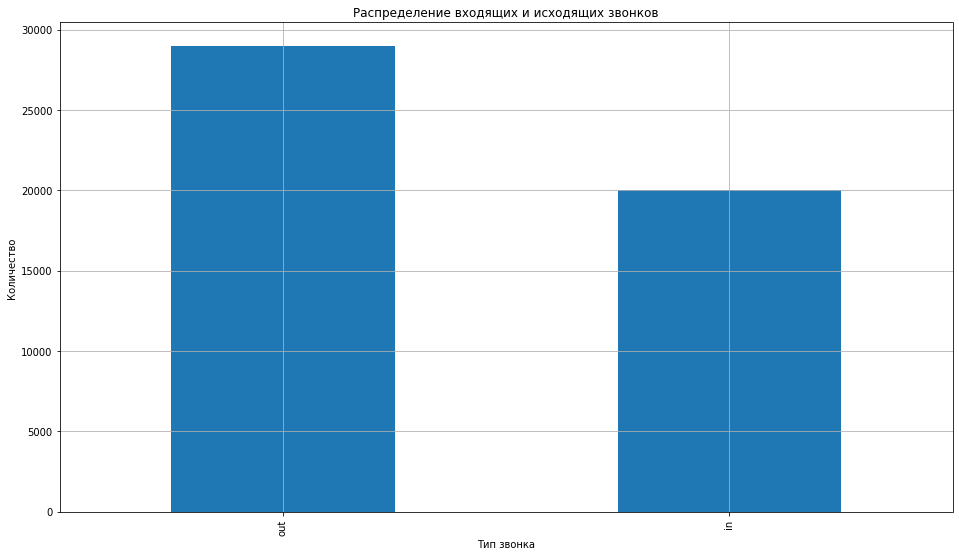

In [40]:
ax = telecom_dataset['direction'].value_counts().plot(kind='bar', grid=True, figsize=(16,9))
plt.title('Распределение входящих и исходящих звонков')
plt.xlabel('Тип звонка')
plt.ylabel('Количество')

По графику выше видно, что исходящих звонокв больше чем входящих на 9000 или 18% от общего количества.

Рассмотрим распеределение количества звонков

In [41]:
telecom_dataset['calls_count'].describe()

count    49000.000000
mean        16.463408
std         63.605319
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

Первым на что хочется обратить внимание это разница между средним (чуть больше 16 звонков) и медианным значением (4). В наших данных присутствуют выбросы. Собственно это видно из максимального значения - 4817. Рассмотрим статистическое распределение количества звонков по операторам по направлению вызова.

In [42]:
stat_out = telecom_dataset[telecom_dataset['direction']=='out']['calls_count']
stat_out.describe()

count    28998.000000
mean        20.996724
std         70.428417
min          1.000000
25%          2.000000
50%          5.000000
75%         18.000000
max       4817.000000
Name: calls_count, dtype: float64

In [43]:
stat_in = telecom_dataset[telecom_dataset['direction']=='in']['calls_count']
stat_in.describe()

count    20002.000000
mean         9.891211
std         51.448901
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max       2168.000000
Name: calls_count, dtype: float64

Наблюдается та же картина что и с общим количеством звонков.

Построим ящик с усами для общего количества звонков

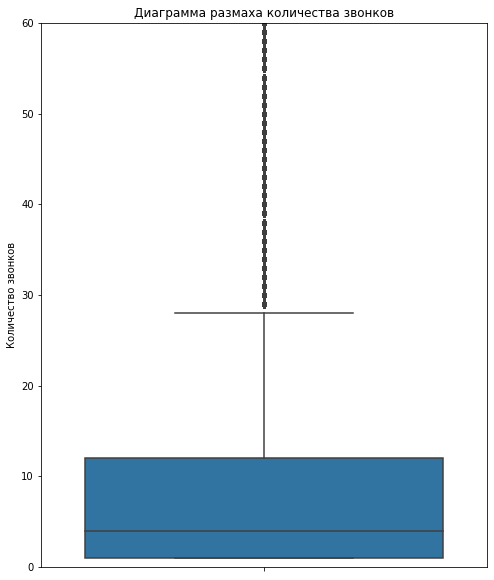

In [44]:
plt.figure(figsize=(8, 10))
plt.ylim(0, 60)
sns.boxplot(y="calls_count", data = telecom_dataset)
plt.title("Диаграмма размаха количества звонков")
plt.ylabel("Количество звонков")
plt.show()

Согласно данным, которые мы видим на диаграмме ящик с усами, выбросы начинаются с 28 звонокв. Избавимся от выбросов и удалим строки из датафрейма, где количество звонков больше 28

In [45]:
telecom_dataset = telecom_dataset.query('calls_count <= 28')

In [46]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42953 entries, 0 to 48999
Data columns (total 15 columns):
user_id                    42953 non-null int64
date                       42953 non-null datetime64[ns]
direction                  42953 non-null object
internal                   42953 non-null bool
operator_id                42953 non-null int64
is_missed_call             42953 non-null bool
calls_count                42953 non-null int64
call_duration              42953 non-null int64
total_call_duration        42953 non-null int64
waiting_time_answers       42953 non-null int64
waiting_time_one_answer    42953 non-null float64
one_call_duration_full     42953 non-null float64
one_call_duration_clean    42953 non-null float64
tariff_plan                42953 non-null object
date_start                 42953 non-null datetime64[ns]
dtypes: bool(2), datetime64[ns](2), float64(3), int64(6), object(2)
memory usage: 4.7+ MB


Рассмотрим значения длительности одного звонка без учета ожидания ответа при нулевой и не нулевой продолжительности звонка в разрезе пропущенных звонков. 

In [47]:
telecom_dataset.query('one_call_duration_clean == 0')['is_missed_call'].value_counts()

True     18527
False       17
Name: is_missed_call, dtype: int64

In [48]:
telecom_dataset.query('one_call_duration_clean != 0')['is_missed_call'].value_counts()

False    24113
True       296
Name: is_missed_call, dtype: int64

Таким образом мы нашли еще данные, являющиеся некорректными для исследования. 17 звонков не являются пропущенными, но длительность равна нулю и 296 звонков имеют ненулевую продолжительности, но обозначены как пропущенные. Удаляем и их. 

In [49]:
telecom_dataset = (telecom_dataset[(~(telecom_dataset['one_call_duration_clean'] == 0) & (telecom_dataset['is_missed_call'] == False)) |
                  ((telecom_dataset['one_call_duration_clean'] == 0) & (telecom_dataset['is_missed_call'] == True))])

In [50]:
telecom_dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.00,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.00,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.00,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.00,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.00,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48994,168606,2019-11-09,out,False,957922,False,4,551,593,42,10.500000,148.250000,137.75,C,2019-10-31
48996,168606,2019-11-10,out,True,957922,True,1,0,38,38,38.000000,38.000000,0.00,C,2019-10-31
48997,168606,2019-11-11,out,True,957922,False,2,479,501,22,11.000000,250.500000,239.50,C,2019-10-31
48998,168606,2019-11-15,out,True,957922,False,4,3130,3190,60,15.000000,797.500000,782.50,C,2019-10-31


### Первые выводы на основании анализа данных

В процессе предобработки данных мы выполнили следующие шаги:
1. Изменили типы данных:
* internal
* operator_id
* date
* date_start
2. Выявили пропущенные значения (8172 пропуска, что составляет около 15%). 97,5% - входящие вызовы, 2,5% - исходящие.
По входящим вызовам было выявлено, что звонки с пропущенными данными оператора составляют около трети от всех пропущенных звонков. Была дана первая рекомендация разобраться техническим специалистам с данной аномалией. Строки с пропущенными значениями удалять не стали, а заполнили самыми часто встречающимся значением айди оператора по каждому клиенту.
3. Объединили датасеты по клиенту и добавили колонки для последующего анализа.
4. Были удалены заведомо ложные наблюдения (17 шт. - звонки не явл. пропущенными, но длительность равна нулю и 296 шт. -  имеют ненулевую продолжительность, но обозначены как пропущенные)

## Исследовательский анализ данных

### Разделение колл-центров(специализация на входящих звонках, исходящих, либо на обоих типах)

Для дальнейшей работы разделим операторов на следующие категории:
1. колл-центры, работающие на обзвон
2. колл-центры, работающие на приём звонков
3. колл-центры,работающие в смешанном режиме

Создадим сводную таблицу для категоризации

In [51]:
telecom_dataset_pivot = telecom_dataset.pivot_table(index=['tariff_plan','user_id', 'operator_id', 'date', 'calls_count'], columns='direction', values='total_call_duration', aggfunc='sum')\
.reset_index()
telecom_dataset_pivot

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out
0,A,166407,888532,2019-08-20,1,NaN,16.0
1,A,166407,888532,2019-08-26,1,22.0,NaN
2,A,166407,888532,2019-09-09,6,NaN,22.0
3,A,166407,888532,2019-09-10,2,242.0,NaN
4,A,166407,888532,2019-09-11,1,39.0,NaN
...,...,...,...,...,...,...,...
38476,C,168606,957922,2019-11-09,4,NaN,593.0
38477,C,168606,957922,2019-11-10,1,NaN,38.0
38478,C,168606,957922,2019-11-11,2,NaN,501.0
38479,C,168606,957922,2019-11-15,4,NaN,3190.0


Заменим пропущенные значения на нули

In [52]:
telecom_dataset_pivot = telecom_dataset_pivot.fillna(0)

Определим столбцы с долями для входящих и исходящих звонков

In [53]:
telecom_dataset_pivot['call_in_perc'] = telecom_dataset_pivot['in'] / (telecom_dataset_pivot['in'] + telecom_dataset_pivot['out']) * 100

In [54]:
telecom_dataset_pivot['call_out_perc'] = telecom_dataset_pivot['out'] / (telecom_dataset_pivot['in'] + telecom_dataset_pivot['out']) * 100

In [55]:
telecom_dataset_pivot.head(5)

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0


Изучим распределение сумм времени звонков среди операторов, затраченных на входящие и исходящие вызовы.

In [56]:
telecom_dataset_pivot['in'].describe()

count    38481.000000
mean       209.014527
std        577.287260
min          0.000000
25%          0.000000
50%          0.000000
75%        115.000000
max      15352.000000
Name: in, dtype: float64

In [57]:
telecom_dataset_pivot['out'].describe()

count    38481.000000
mean       354.467348
std        879.795178
min          0.000000
25%          0.000000
50%         22.000000
75%        275.000000
max      18283.000000
Name: out, dtype: float64

Представляется наиболее приемлемым произвести категоризацию по 75 % перцентилю

In [58]:
def quantile_call(column, percent):
    count = 0
    for i in telecom_dataset_pivot[column]:
        if i >= percent:
            count += 1
        else:
            continue
    return count    

In [59]:
quant_in = quantile_call('call_in_perc', 75)
quant_in

16450

In [60]:
quant_out = quantile_call('call_out_perc', 75)
quant_out

20229

In [61]:
mix = len(telecom_dataset_pivot) - quant_in - quant_out
mix

1802

Добавим столбцы, определяющие направление звонка. 

In [62]:
telecom_dataset_pivot['incoming call'] = telecom_dataset_pivot['call_in_perc'] >= 75

In [63]:
telecom_dataset_pivot['outgoing call'] = telecom_dataset_pivot['call_out_perc'] >= 75

In [64]:
telecom_dataset_pivot['mixed challenge'] = 1 - telecom_dataset_pivot['incoming call'] - telecom_dataset_pivot['outgoing call'] 

In [65]:
telecom_dataset_pivot = telecom_dataset_pivot.replace(False, 0)
    
telecom_dataset_pivot = telecom_dataset_pivot.replace(True, 1)    

In [66]:
telecom_dataset_pivot

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call,mixed challenge
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,0.0,1.0,0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,1.0,0.0,0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,0.0,1.0,0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,1.0,0.0,0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
38476,C,168606,957922,2019-11-09,4,0.0,593.0,0.0,100.0,0.0,1.0,0
38477,C,168606,957922,2019-11-10,1,0.0,38.0,0.0,100.0,0.0,1.0,0
38478,C,168606,957922,2019-11-11,2,0.0,501.0,0.0,100.0,0.0,1.0,0
38479,C,168606,957922,2019-11-15,4,0.0,3190.0,0.0,100.0,0.0,1.0,0


In [67]:
call_pivot = telecom_dataset_pivot[['incoming call', 'outgoing call', 'mixed challenge']]
call_pivot

direction,incoming call,outgoing call,mixed challenge
0,0.0,1.0,0
1,1.0,0.0,0
2,0.0,1.0,0
3,1.0,0.0,0
4,1.0,0.0,0
...,...,...,...
38476,0.0,1.0,0
38477,0.0,1.0,0
38478,0.0,1.0,0
38479,0.0,1.0,0


Text(0, 0.5, 'Количество')

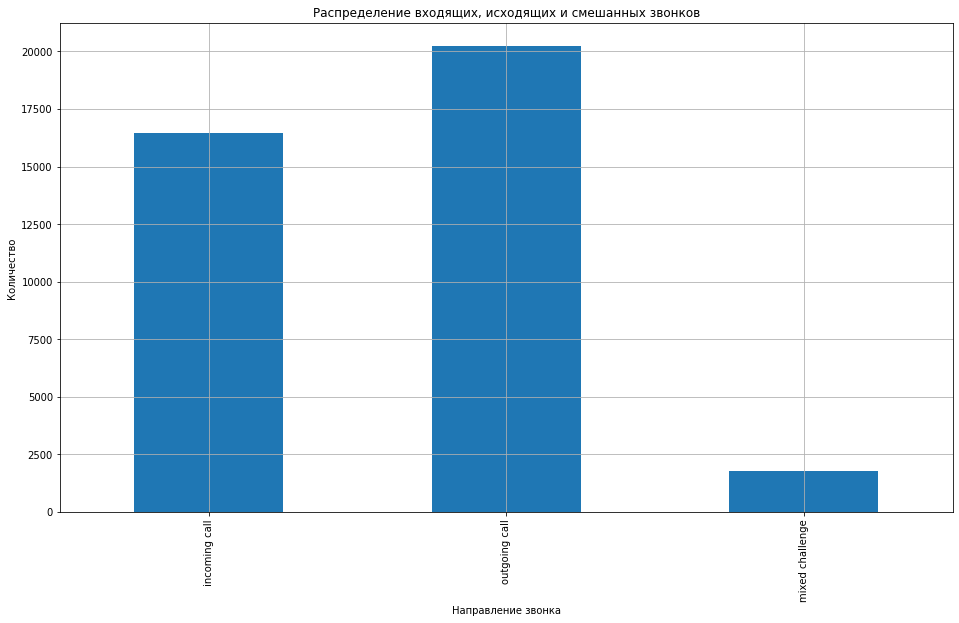

In [68]:
ax = call_pivot.sum().plot(kind='bar', grid=True, figsize=(16,9))
plt.title('Распределение входящих, исходящих и смешанных звонков')
plt.xlabel('Направление звонка')
plt.ylabel('Количество')

Как мы видим из графика выше основная специализация - исходящие звонки.
Сложилось следующее распределение:
* специализация на входящих звонках - 16450;
* специализация на исходящих звонках - 20229;
* специализация на смешанных звонках - 1802

Проверим является ли значимым фактор тарифа

In [69]:
telecom_dataset_pivot['tariff_plan'].value_counts()

C    14981
B    14354
A     9146
Name: tariff_plan, dtype: int64

In [70]:
def tariff_call_connection(call):
    tariff = ['A', 'B', 'C']
    for i in tariff:
        
        print(i, telecom_dataset_pivot[(telecom_dataset_pivot['tariff_plan']==i) & (telecom_dataset_pivot[call]==1)][call].sum())

Входящие вызовы

In [71]:
tariff_call_connection('incoming call')

A 3722.0
B 5665.0
C 7063.0


Исходящие вызовы

In [72]:
tariff_call_connection('outgoing call')

A 4992.0
B 8101.0
C 7136.0


Смешанные вызовы

In [73]:
tariff_call_connection('mixed challenge')

A 432
B 588
C 782


Как мы видим выбор тарифа не связан со специализацией

### Проведение анализа нагрузки на операторов

In [74]:
telecom_dataset_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call,mixed challenge
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,0.0,1.0,0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,1.0,0.0,0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,0.0,1.0,0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,1.0,0.0,0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,1.0,0.0,0


Распределим операторов по трём категориям исходя из специализации работы колл-центра

Входящие вызовы

In [75]:
incoming_df = telecom_dataset_pivot[telecom_dataset_pivot['incoming call']==1]
incoming_df = incoming_df[['user_id', 'operator_id', 'in', 'date', 'calls_count']]
incoming_df

direction,user_id,operator_id,in,date,calls_count
1,166407,888532,22.0,2019-08-26,1
3,166407,888532,242.0,2019-09-10,2
4,166407,888532,39.0,2019-09-11,1
27,166407,888532,802.0,2019-10-08,1
35,166407,888532,330.0,2019-10-16,1
...,...,...,...,...,...
38467,168601,952914,19.0,2019-11-28,1
38470,168601,952916,186.0,2019-11-12,1
38473,168606,957922,7.0,2019-11-08,1
38475,168606,957922,121.0,2019-11-08,6


Исходящие вызовы

In [76]:
outgoing_df = telecom_dataset_pivot[telecom_dataset_pivot['outgoing call']==1]
outgoing_df = outgoing_df[['user_id', 'operator_id', 'out', 'date', 'calls_count']]
outgoing_df

direction,user_id,operator_id,out,date,calls_count
0,166407,888532,16.0,2019-08-20,1
2,166407,888532,22.0,2019-09-09,6
5,166407,888532,162.0,2019-09-11,7
6,166407,888532,50.0,2019-09-13,1
7,166407,888532,21.0,2019-09-16,1
...,...,...,...,...,...
38472,168601,952916,232.0,2019-11-15,2
38476,168606,957922,593.0,2019-11-09,4
38477,168606,957922,38.0,2019-11-10,1
38478,168606,957922,501.0,2019-11-11,2


Смешанные вызовы

In [77]:
mixed_df = telecom_dataset_pivot[telecom_dataset_pivot['mixed challenge']==1]
mixed_df = mixed_df[['user_id', 'operator_id', 'in', 'out', 'date', 'calls_count']]
mixed_df

direction,user_id,operator_id,in,out,date,calls_count
39,166407,888532,187.0,89.0,2019-10-21,2
79,166407,888534,72.0,31.0,2019-09-11,1
88,166407,888534,57.0,37.0,2019-09-16,2
92,166407,888534,93.0,34.0,2019-09-18,2
95,166407,888534,32.0,22.0,2019-09-20,1
...,...,...,...,...,...,...
38347,168466,952114,9.0,11.0,2019-11-15,1
38351,168466,952114,0.0,0.0,2019-11-18,10
38415,168598,958394,0.0,0.0,2019-11-28,2
38450,168601,952914,0.0,0.0,2019-11-16,1


Рассмотрим пиковые дни для операторов, работающих с входяшими вызовами

In [78]:
pik_date_in = incoming_df.set_index('date')['in'].sort_values(ascending=False).head(20)
pik_date_in

date
2019-11-20    15352.0
2019-11-12    14181.0
2019-11-14    13662.0
2019-11-11    13557.0
2019-11-13    13391.0
2019-11-08     8998.0
2019-11-23     8623.0
2019-10-28     8228.0
2019-11-18     7638.0
2019-11-26     7537.0
2019-11-01     7439.0
2019-11-06     7322.0
2019-09-16     7134.0
2019-09-13     7108.0
2019-09-23     6820.0
2019-09-16     6766.0
2019-11-25     6628.0
2019-11-18     6596.0
2019-11-15     6583.0
2019-10-24     6420.0
Name: in, dtype: float64

Text(0, 0.5, 'Продолжительность переговоров')

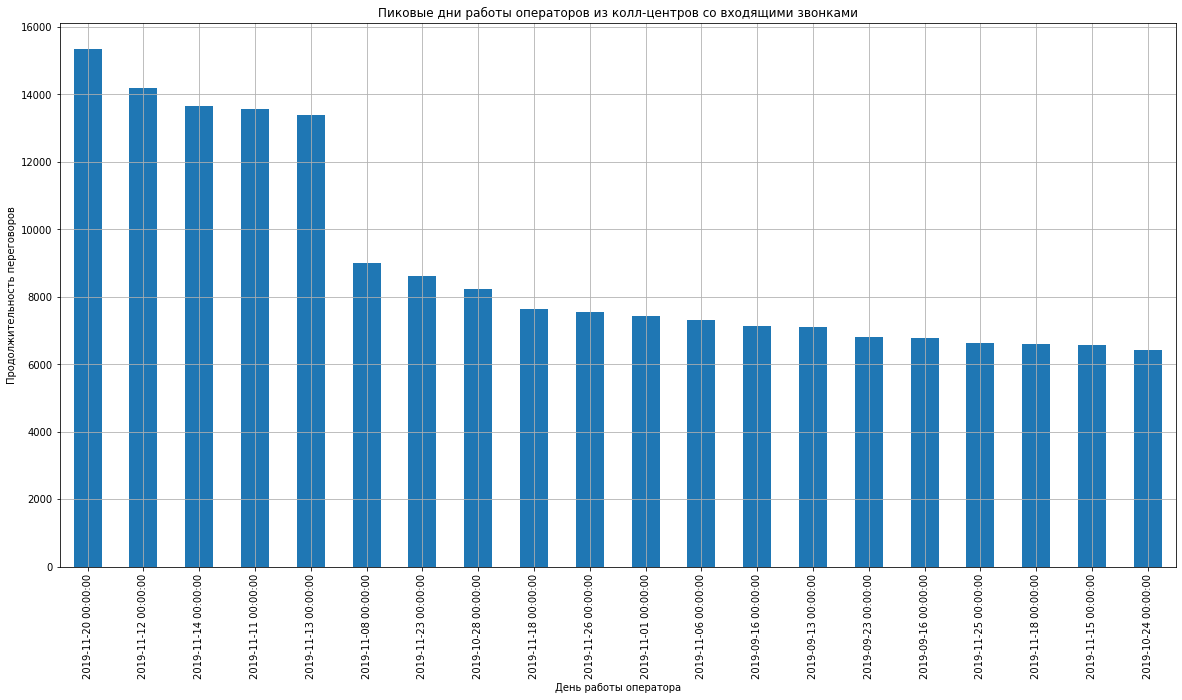

In [79]:
pik_date_in.plot(
    kind='bar',
    grid=True,
    figsize=(20, 10))

plt.title('Пиковые дни работы операторов из колл-центров со входящими звонками')
plt.xlabel('День работы оператора') 
plt.ylabel('Продолжительность переговоров')   

Выделяются 5 самых пиковых дня работы операторов со входящими звонками:
* 20 ноября
* 12 ноября
* 14 ноября
* 11 ноября 
* 13 ноября

Сделаем то же самое по количеству, а не по продолжительности

In [80]:
max_load_call_in_days = incoming_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_in_days

date
2019-08-31     3061
2019-09-30    13313
2019-10-31    27996
2019-11-30    36595
Freq: M, Name: calls_count, dtype: int64

Максимальное количество звонков поступивших операторам от абонентов происходила:

* 31 августа
* 30 сентября
* 31 октября
* 30 ноября

Опираясь на полученные данные выше мы видим, что загрузка операторов по времени не является причиной увеличенного количества звонков. Однако, мы обнаружили любопытный факт - максимальное количество входящих звонков приходится на последние дни месяца.Возможно это связано с окончанием платежного периода, отчетности  и т.д., иными словами причина в специфике компаний.

Проделаем те же самые трюки для исходящих звонков и смешанных.

In [81]:
max_load_call_out_days = outgoing_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_out_days

date
2019-08-31     6037
2019-09-30    24146
2019-10-31    49204
2019-11-30    68522
Freq: M, Name: calls_count, dtype: int64

In [82]:
max_load_call_mix_days = mixed_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_mix_days

date
2019-08-31     175
2019-09-30     776
2019-10-31    1571
2019-11-30    2131
Freq: M, Name: calls_count, dtype: int64

ОСНОВНОЙ ВЫВОД:
* Вышеуказанные результаты отчетливо показывают и подтверждают, что для всех категорий пиковыми днями являются последние календарные дни месяца. 

### Исследовательский анализ данных. Алгоритм выявления неэффективных операторов.

У нас есть 3 признака низкой эффективности:
* много пропущенных входящих вызовов;
* долгое ожидания ответа при входящих внешних вызовах;
* мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков;

Для будущего построения алгоритма на данном этапе необходимо количественно определить "много" и "мало" наших вводных. Начнем по порядку. 

#### много пропущенных входящих вызовов

In [83]:
incoming_missed_call = telecom_dataset[(telecom_dataset['direction']=='in') & (telecom_dataset['is_missed_call']==True)]
incoming_missed_call

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
7,166377,2019-08-05,in,False,880028,True,6,0,35,35,5.833333,5.833333,0.0,B,2019-08-01
8,166377,2019-08-06,in,False,880028,True,4,0,62,62,15.500000,15.500000,0.0,B,2019-08-01
16,166377,2019-08-07,in,False,880028,True,2,0,24,24,12.000000,12.000000,0.0,B,2019-08-01
26,166377,2019-08-12,in,False,880028,True,2,0,34,34,17.000000,17.000000,0.0,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48980,168601,2019-11-28,in,False,952914,True,1,0,19,19,19.000000,19.000000,0.0,C,2019-10-31
48988,168603,2019-11-28,in,False,959118,True,1,0,30,30,30.000000,30.000000,0.0,B,2019-10-31
48990,168606,2019-11-08,in,False,957922,True,1,0,7,7,7.000000,7.000000,0.0,C,2019-10-31
48992,168606,2019-11-08,in,False,957922,True,6,0,121,121,20.166667,20.166667,0.0,C,2019-10-31


In [84]:
pivot_missed_call = incoming_missed_call.pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()\
.sort_values(by='calls_count', ascending=False)
pivot_missed_call

,operator_id,calls_count
5,882686,920
28,890404,771
179,919552,612
180,919792,597
224,928888,595
...,...,...
248,934076,1
243,933070,1
60,896538,1
240,932460,1


In [85]:
pivot_missed_call['calls_count'].describe()

count    380.000000
mean      77.973684
std      130.516507
min        1.000000
25%        4.000000
50%       23.000000
75%       83.250000
max      920.000000
Name: calls_count, dtype: float64

Посмотрим, как отображается распределение пропусков входящих вызовов операторами на графике

Построим ящик с усами

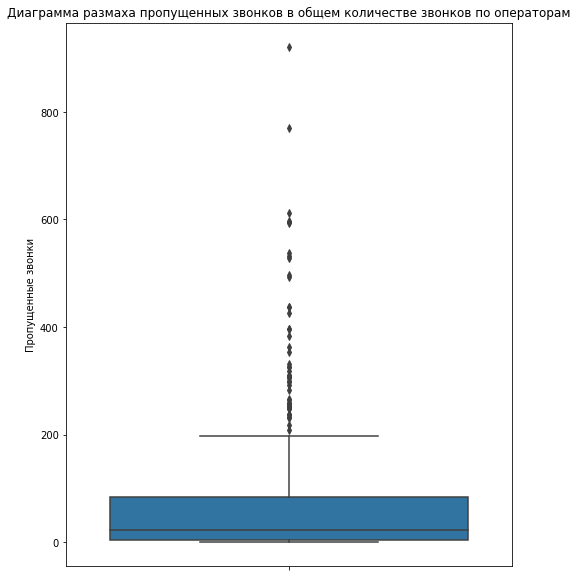

In [86]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="calls_count", data = pivot_missed_call)
plt.title("Диаграмма размаха пропущенных звонков в общем количестве звонков по операторам")
plt.ylabel("Пропущенные звонки")
plt.show()

Согласно диаграмме выбросы начинаются после значения 200. Чуть выше в 3 квантили (75%) мы получили значение 83. Сравним с 80% квантилью

In [87]:
pivot_missed_call['calls_count'].quantile(.8)

113.19999999999999

Итак, мы можем выделить границы для операторов, попадающих под первый признак неэффективности - много пропущенных вызовов. 
Много мы характеризуем как явно превышающее третью квартиль, но меньше порога выбросов.В качестве такого ограничения возьмем восьмую квантиль.

In [88]:
first_sign_of_inefficiency = pivot_missed_call.query('calls_count > calls_count.quantile(.8)')
first_sign_of_inefficiency

,operator_id,calls_count
5,882686,920
28,890404,771
179,919552,612
180,919792,597
224,928888,595
...,...,...
208,925826,115
42,893402,115
96,902720,114
59,896536,114


Итак, мы выделили 76 неэффективно работающих операторов по количеству пропущенных звонков.

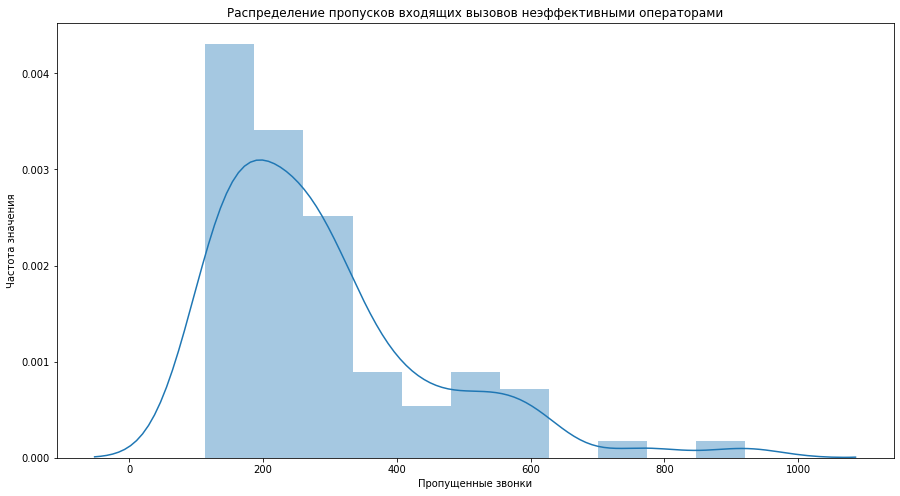

In [89]:
#график для презентации 
plt.figure(figsize=(15, 8))
sns.distplot(first_sign_of_inefficiency['calls_count'])
plt.title('Распределение пропусков входящих вызовов неэффективными операторами', size=12)
plt.xlabel("Пропущенные звонки")
plt.ylabel("Частота значения")
plt.show()

#### долгое ожидания ответа при входящих внешних вызовах

In [90]:
incoming_waiting_call = telecom_dataset.query('direction=="in"')
incoming_waiting_call

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
7,166377,2019-08-05,in,False,880028,True,6,0,35,35,5.833333,5.833333,0.0,B,2019-08-01
8,166377,2019-08-06,in,False,880028,True,4,0,62,62,15.500000,15.500000,0.0,B,2019-08-01
16,166377,2019-08-07,in,False,880028,True,2,0,24,24,12.000000,12.000000,0.0,B,2019-08-01
25,166377,2019-08-12,in,False,880028,False,1,407,411,4,4.000000,411.000000,407.0,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48988,168603,2019-11-28,in,False,959118,True,1,0,30,30,30.000000,30.000000,0.0,B,2019-10-31
48990,168606,2019-11-08,in,False,957922,True,1,0,7,7,7.000000,7.000000,0.0,C,2019-10-31
48992,168606,2019-11-08,in,False,957922,True,6,0,121,121,20.166667,20.166667,0.0,C,2019-10-31
48993,168606,2019-11-08,in,False,957922,False,2,686,705,19,9.500000,352.500000,343.0,C,2019-10-31


In [91]:
pivot_waiting_call = incoming_waiting_call.pivot_table(index='operator_id', values='waiting_time_one_answer')\
.sort_values(by='waiting_time_one_answer', ascending=False).reset_index()
pivot_waiting_call

,operator_id,waiting_time_one_answer
0,905842,115.500000
1,917680,100.000000
2,907174,65.187500
3,960296,63.000000
4,920930,62.000000
...,...,...
780,926872,0.947917
781,932672,0.900000
782,940430,0.869444
783,940442,0.678944


In [92]:
pivot_waiting_call.describe()

,operator_id,waiting_time_one_answer
count,785.000000,785.000000
mean,923626.568153,17.798379
std,22500.314603,12.182831
min,879896.000000,0.285714
25%,905430.000000,9.866667
50%,924544.000000,15.000000
75%,940440.000000,22.646223
max,973286.000000,115.500000


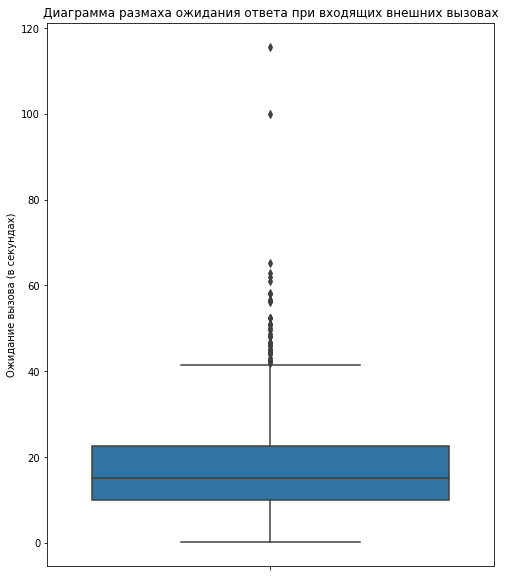

In [93]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="waiting_time_one_answer", data = pivot_waiting_call)
plt.title("Диаграмма размаха ожидания ответа при входящих внешних вызовах")
plt.ylabel("Ожидание вызова (в секундах)")
plt.show()

In [94]:
pivot_waiting_call['waiting_time_one_answer'].quantile(.8)

25.0

Выделим операторов попадающих под второй признак неэффективности - долгое ожидания ответа при входящих внешних вызовах. Определим понятие "долгое", как ожидание превышающее 25 секунд

In [95]:
second_sign_of_inefficiency = pivot_waiting_call[pivot_waiting_call['waiting_time_one_answer']>25].reset_index()
second_sign_of_inefficiency

,index,operator_id,waiting_time_one_answer
0,0,905842,115.500000
1,1,917680,100.000000
2,2,907174,65.187500
3,3,960296,63.000000
4,4,920930,62.000000
...,...,...,...
148,148,933996,25.500000
149,149,969272,25.476786
150,150,912296,25.268506
151,151,933832,25.141333


По второму признаку неэффективности зафиксировано 153 оператора

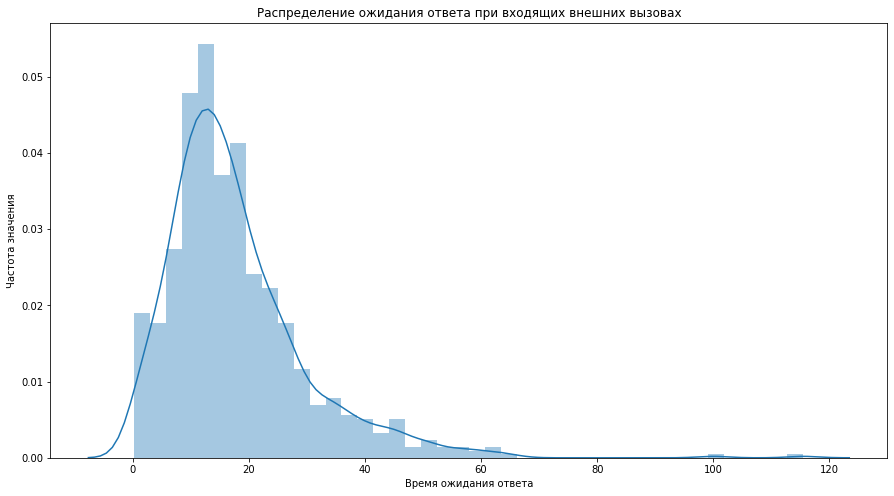

In [96]:
# график для презентации
plt.figure(figsize=(15, 8))
sns.distplot(pivot_waiting_call['waiting_time_one_answer'])
plt.title('Распределение ожидания ответа при входящих внешних вызовах', size=12)
plt.xlabel("Время ожидания ответа")
plt.ylabel("Частота значения")
plt.show()

#### мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков

In [97]:
outgoing_few_calls = telecom_dataset[telecom_dataset['direction']=='out']
outgoing_few_calls

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.00,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.00,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.00,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.00,B,2019-08-01
5,166377,2019-08-05,out,False,880020,False,2,3,29,26,13.000000,14.500000,1.50,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48991,168606,2019-11-08,out,False,957922,False,2,255,328,73,36.500000,164.000000,127.50,C,2019-10-31
48994,168606,2019-11-09,out,False,957922,False,4,551,593,42,10.500000,148.250000,137.75,C,2019-10-31
48996,168606,2019-11-10,out,True,957922,True,1,0,38,38,38.000000,38.000000,0.00,C,2019-10-31
48997,168606,2019-11-11,out,True,957922,False,2,479,501,22,11.000000,250.500000,239.50,C,2019-10-31


In [98]:
pivot_few_calls = outgoing_few_calls.pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
pivot_few_calls

,operator_id,calls_count
0,879896,447
1,879898,886
2,880020,38
3,880022,189
4,880026,1919
...,...,...
868,972408,6
869,972410,77
870,972412,60
871,972460,50


In [99]:
pivot_few_calls.describe()

,operator_id,calls_count
count,873.000000,873.000000
mean,925658.703322,180.499427
std,22936.762141,300.258838
min,879896.000000,1.000000
25%,906392.000000,10.000000
50%,924960.000000,52.000000
75%,944210.000000,224.000000
max,973120.000000,2127.000000


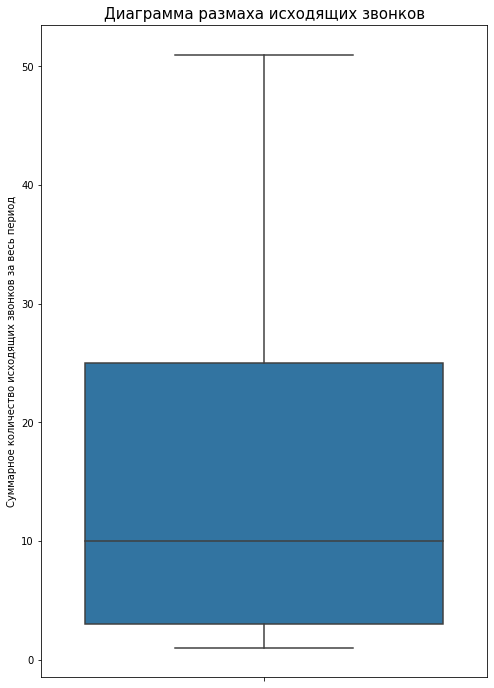

In [100]:
plt.figure(figsize=(8, 12))
sns.boxplot(y="calls_count", data = pivot_few_calls.query('calls_count < calls_count.median()'))
plt.title("Диаграмма размаха исходящих звонков", size=15)
plt.ylabel("Суммарное количество исходящих звонков за весь период")
plt.show()

Выделим операторов попадающих под третий признак неэффективности - мало исходящих вызовов. Определим понятие "мало", как менее или равно 10 %, переданные в качестве аргумента методу quantile

In [101]:
pivot_few_calls['calls_count'].quantile(.1)

2.0

In [102]:
third_sign_of_inefficiency = pivot_few_calls[pivot_few_calls['calls_count']\
                                                 <=pivot_few_calls['calls_count']\
                                                 .quantile(.1)]
third_sign_of_inefficiency

,operator_id,calls_count
8,882478,1
13,883018,2
14,883898,1
45,890234,1
64,891192,1
...,...,...
854,969288,2
859,970240,1
861,970244,2
862,970250,1


По третьему признаку неэффективности зафиксировано 93 оператора (10 % от числа всех операторов с исходящими вызовами) - операторы совершившие в совокупной сложности от 1 до 2 звонков за весь период

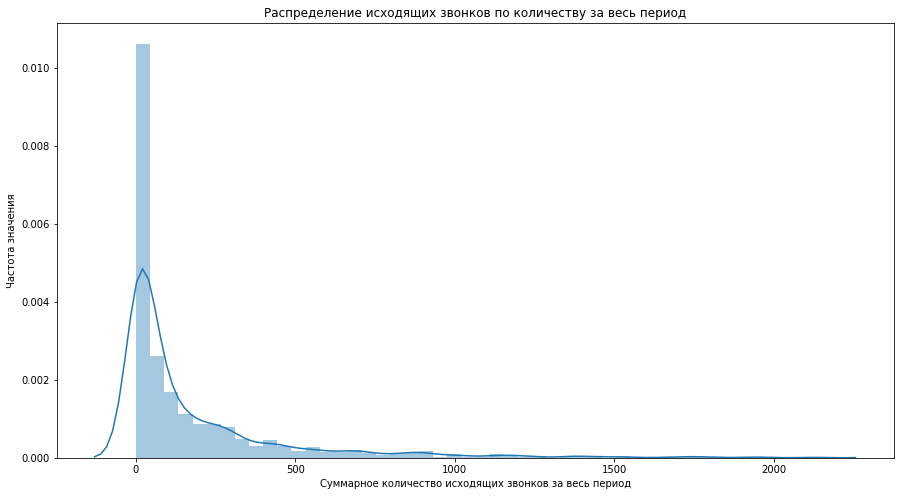

In [103]:
#график для презентации
plt.figure(figsize=(15, 8))
sns.distplot(pivot_few_calls['calls_count'])
plt.title('Распределение исходящих звонков по количеству за весь период', size=12)
plt.xlabel("Суммарное количество исходящих звонков за весь период")
plt.ylabel("Частота значения")
plt.show()

Теперь определим операторов, попадающих в несколько групп для идентификации и подсчета полного количества

Для начала выделим тех операторов, которые входят в группу неэффективных по двум первым признакам

In [104]:
inefficient_incoming_operators = first_sign_of_inefficiency.merge(second_sign_of_inefficiency, on='operator_id')
inefficient_incoming_operators

,operator_id,calls_count,index,waiting_time_one_answer
0,919552,612,68,34.835725
1,919792,597,80,33.083651
2,902744,437,152,25.027655
3,924960,308,121,27.506334
4,887276,292,144,25.744289
5,944220,253,78,33.295919
6,894224,250,96,30.264258
7,899932,233,82,32.716512
8,892532,230,134,26.462563
9,906680,218,30,44.597599


В итоговую таблицу по неэффективным операторам, принимающим входящие звонки попали 12 операторов

In [105]:
inefficient_outgoing_operators = third_sign_of_inefficiency.merge(outgoing_df, on='operator_id')
inefficient_outgoing_operators

,operator_id,calls_count_x,user_id,out,date,calls_count_y
0,883018,2,166507,15.0,2019-08-07,2
1,883898,1,166507,80.0,2019-08-07,1
2,890234,1,166520,97.0,2019-08-17,1
3,891192,1,166520,1338.0,2019-08-25,1
4,891250,2,166711,128.0,2019-08-20,2
...,...,...,...,...,...,...
68,969284,1,168336,4.0,2019-11-25,1
69,969288,2,168155,21.0,2019-11-24,2
70,970244,2,168225,23.0,2019-11-28,1
71,970250,1,168225,8.0,2019-11-28,1


In [106]:
len(inefficient_outgoing_operators['operator_id'].unique())

68

В итоговую таблицу неэффективных операторов с учётом вхождения их в категорию колл-центров, специализирующихся на обзвонах, попали 68 уникальных оператора

## Определение клиетов(колл-центров), потенциально заинтересованных в получении результатов данного исследования

Определим клиентов, потенциально заинтересованных в предложении услуг. Для этого создадим две переменные: с id неэффективных операторов входящих звонков и с id неэффективных операторов исходящих звонков

In [107]:
inefficient_operator_id_in = inefficient_incoming_operators['operator_id']
inefficient_operator_id_out = inefficient_outgoing_operators['operator_id'].unique()

In [108]:
inefficient_operator_id_in
inefficient_operator_id_out

interested_clients = (telecom_dataset.query('operator_id in @inefficient_operator_id_in or operator_id in @inefficient_operator_id_out')
                                   .pivot_table(index = ['user_id', 'operator_id'],
                                                values = 'calls_count', aggfunc = 'sum')
                                   .reset_index().sort_values(by = 'calls_count', ascending = False))
interested_clients

,user_id,operator_id,calls_count
32,167264,919552,1660
0,166485,887276,1627
37,167521,919792,1352
27,167125,902744,842
77,168416,948182,722
...,...,...,...
51,168062,947596,1
5,166520,891192,1
17,166884,917890,1
46,167626,934426,1


In [109]:
interested_clients['user_id'].unique()

array([167264, 166485, 167521, 167125, 168416, 167977, 167497, 166503,
       167011, 166800, 166732, 166836, 168252, 167436, 167189, 166541,
       167948, 166874, 167551, 167599, 167364, 168412, 168500, 167626,
       166713, 167930, 167580, 168155, 168481, 168307, 166520, 168225,
       167532, 166507, 166680, 167016, 166916, 167110, 166774, 166813,
       167012, 166711, 167250, 166939, 167183, 168336, 168361, 167176,
       168187, 168073, 167078, 168062, 166884])

In [110]:
len(interested_clients['user_id'].unique())

53

Получен список из 53 клиентов, кому было бы интересно и необходимо узнать список неэффективных операторо для принятия мер. Определим какое количество операторов имеет клиент. 

In [111]:
for i in interested_clients['user_id'].unique():
    count = []
    
    for k, j in zip(interested_clients['user_id'],  interested_clients['operator_id']):
        if i == k:
            count.append(j)
    print(f'Количество неэффективных операторов клиента с id: {i}, равно {len(count)}, неэффективные операторы: {count}')

Количество неэффективных операторов клиента с id: 167264, равно 1, неэффективные операторы: [919552]
Количество неэффективных операторов клиента с id: 166485, равно 1, неэффективные операторы: [887276]
Количество неэффективных операторов клиента с id: 167521, равно 3, неэффективные операторы: [919792, 944246, 944560]
Количество неэффективных операторов клиента с id: 167125, равно 1, неэффективные операторы: [902744]
Количество неэффективных операторов клиента с id: 168416, равно 1, неэффективные операторы: [948182]
Количество неэффективных операторов клиента с id: 167977, равно 1, неэффективные операторы: [944220]
Количество неэффективных операторов клиента с id: 167497, равно 1, неэффективные операторы: [924960]
Количество неэффективных операторов клиента с id: 166503, равно 1, неэффективные операторы: [906680]
Количество неэффективных операторов клиента с id: 167011, равно 1, неэффективные операторы: [899932]
Количество неэффективных операторов клиента с id: 166800, равно 1, неэффект

In [112]:
rank1 = []
rank2 = []
rank3 = []

for i in interested_clients['user_id'].unique():
    count = []
    
    for k, j in zip(interested_clients['user_id'],  interested_clients['operator_id']):
        if i == k:
            count.append(j)
    if len(count) <= 2:
        rank3.append(i)
    elif 2 < len(count) < 5:
        rank2.append(i)
    else:
        rank1.append(i)
        
    
print(f'Наиболее перспективные клиенты с id: {rank1}, имеющие более пяти операторов') 
print()
print(f'Перспективные клиенты с id: {rank2}, имеющие более двух операторов')
print()
print(f'Наименее перспективные клиенты с id: {rank3}, имеющие 1-2 операторов и способные справиться с ситуацией самостоятельно')

Наиболее перспективные клиенты с id: [168252, 168187], имеющие более пяти операторов

Перспективные клиенты с id: [167521, 166520, 168225, 168073], имеющие более двух операторов

Наименее перспективные клиенты с id: [167264, 166485, 167125, 168416, 167977, 167497, 166503, 167011, 166800, 166732, 166836, 167436, 167189, 166541, 167948, 166874, 167551, 167599, 167364, 168412, 168500, 167626, 166713, 167930, 167580, 168155, 168481, 168307, 167532, 166507, 166680, 167016, 166916, 167110, 166774, 166813, 167012, 166711, 167250, 166939, 167183, 168336, 168361, 167176, 167078, 168062, 166884], имеющие 1-2 операторов и способные справиться с ситуацией самостоятельно


Выводы
* По первому признаку неэффективности (много пропущенных входящих вызовов) обнаружено 76 операторов с общим пропуском от 114 до 920 звонков;
* По второму признаку неэффективности (долгое ожидание ответа при входящих внешних вызовах) выявлено 153 оператора со временем ожидания от 25 секунд до 115 секунд)
* По третьему признаку неэффективности (мало исходящих вызовов) выявлено 93 оператора совершившие 1-2 звонка за весь рассматриваемый период.

Объединив первые 2 признака мы выявили 12 операторов. По третьему признаку после определения операторов к кагорте колл-центров, заточенных на обзвонах осталось 68 неэффективных операторов. 

Потенциально заинтересованных клиентов мы получили - 53. И ранжировали их на наиболее перспективных с более 5 операторами (2 клиента), перспективных с более 2 операторами (4 клиента) и наимее перспективных имеющих 1-2 оператора (46 клиентов). 

## Формулирование и проверка статистических гипотез

* Гипотеза 1:
    - Н0: Время ожидания звонка зависит от тарифного плана;
    - Н1: Время ожидания звонка не зависит от тарифного плана.
* Гипотеза 2:
    - Н0: Среднее время ожидания ответа оператора равно среднему времени ожидания ответа абонента;
    - Н1: Среднее время ожидания ответа оператора не равно среднему времени ожидания ответа абонента.

Перед переходом к исследованию основных гипотез, проверим данные на нормальность распределения данных.

- Н0: Данные распределены нормально
- Н1: Данные не имеют нормального распределения.

In [113]:
stat, p = scipy.stats.shapiro(telecom_dataset.query('tariff_plan == "A" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности')         

Statistics=0.766, p-value=0.000
Отклонить гипотезу о нормальности


In [114]:
stat, p = scipy.stats.shapiro(telecom_dataset.query('tariff_plan == "B" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности')  

Statistics=0.703, p-value=0.000
Отклонить гипотезу о нормальности


In [115]:
stat, p = scipy.stats.shapiro(telecom_dataset.query('tariff_plan == "C" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности')  

Statistics=0.737, p-value=0.000
Отклонить гипотезу о нормальности


Отклоняем нулевую гипотезу "Данные распределены нормально"

Проверим, существуют ли статистически достоверные различия между выборками с разными тарифными планами. Для этого сравним попарно тарифные планы "А", "В" и "С" между собой. Если между выборками будут существовать различия по одним и тем же условиям, то и нулевая гипотеза заказчика о зависимости времени ожидания звонка от тарифного плана также будет справедливой.

Сформулируем промежуточные гипотезы:

Н0: время ожидания звонка тарифного плана "А" равно времени ожидания звонка тарифного плана "В"
Н1: время ожидания звонка тарифного плана "А" не равно времени ожидания звонка тарифного плана "В"

In [116]:
alpha = 0.05

results = st.mannwhitneyu(
    telecom_dataset.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    telecom_dataset.query('tariff_plan == "B" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение: 2.453173503880992e-134
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что время ожидания звонка тарифного плана "А" равно времени ожидания звонка тарифного плана "В" 

Сравним тарифные планы "В" и "С".

Сформулируем промежуточные гипотезы:

Н0: время ожидания звонка тарифного плана "В" равно времени ожидания звонка тарифного плана "С"
Н1: время ожидания звонка тарифного плана "В" не равно времени ожидания звонка тарифного плана "С"

In [117]:
alpha = 0.05

results = st.mannwhitneyu(
    telecom_dataset.query('tariff_plan == "B" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    telecom_dataset.query('tariff_plan == "C" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.956580150605678e-181
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что время ожидания звонка тарифного плана "B" равно времени ожидания звонка тарифного плана "C"

Сравним последние два тарифных плана: "А" и "С".

Сформулируем промежуточные гипотезы:

Н0: время ожидания звонка тарифного плана "А" равно времени ожидания звонка тарифного плана "С"
Н1: время ожидания звонка тарифного плана "А" не равно времени ожидания звонка тарифного плана "С"

In [118]:
alpha = 0.05

results = st.mannwhitneyu(
    telecom_dataset.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    telecom_dataset.query('tariff_plan == "C" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.942055841795758e-109
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что время ожидания звонка тарифного плана "A" равно времени ожидания звонка тарифного плана "C"

Вывод по гипотезе 1: Время ожидания звонка зависит от тарифного плана. Нулевая гипотеза подтвердилась.

Проверим гипотезу 2

- Н0: Среднее время ожидания ответа оператора равно среднему времени ожидания ответа абонента;
- Н1: Среднее время ожидания ответа оператора не равно среднему времени ожидания ответа абонента;

In [119]:
alpha = 0.05

results = st.ttest_ind(
    telecom_dataset.query('direction == "in" and is_missed_call == False and internal == False')['waiting_time_one_answer'], 
    telecom_dataset.query('direction == "out" and is_missed_call == False and internal == False')['waiting_time_one_answer'],\
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.840050424645523e-106
Отвергаем нулевую гипотезу


Не удалось подтвердить гипотезу о равенстве среднего ожидания ответа на звонок между операторами и абонентами

## Выводы и рекомендации

Проведя исследование были получены следующие выводы:
- 15% данных имеют пропущенные значения по столбцу id оператора. Анализ показал, что 97,5% приходится на входящие вызовы и 2,5% на исходящие. Почти 99% данных где пропущены данные - пропущенные звонки. Необходимо дать задание техническим специалистам проанализировать работу и внести корректировки для устранения данного недочета.
- Были выделены 3 направления работы колл-центров(при этом доп. исследование показало, что зависимости между специализацией и тарифом нету):
        * специализация на входящих звонках - 16450;
        * специализация на исходящих звонках - 20229;
        * специализация на смешанных звонках - 1802.
- Были выделены пиковые дни работы операторов(по количеству звонков). Во всех случаях это последний календарный день месяца.
- Были выявлены операторы, удовлетворяющие критериям неуспешности операторов:
        - много пропущенных входящих вызовов - 76 операторов;
        - долгое ожидания ответа при входящих внешних вызовах - 153 оператора;
        - мало исходящих вызовов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков - 93 оператора.
- При объединении первых двух признаков, в итоговую таблицу по неэффективным операторам, принимающим входящие звонки попали 12 операторов. В итоговую таблицу неэффективных операторов с учётом вхождения их в категорию колл-центров, специализирующихся на обзвонах, попали 68 уникальных оператора.
- При определении колл-центров, заинтересованных в результатах нашего исследования, было определено 53 клиента, которым было бы потенциально интересно ознакомиться с результатами исследования:
        - Наиболее перспективные клиенты с id: [168252, 168187], имеющие более пяти операторов;
        - Перспективные клиенты с id: [167521, 166520, 168225, 168073], имеющие более двух операторов;
        - Наименее перспективные клиенты (остальные).
- Были отвергнуты гипотезы об одинаковом времени ожидания в зависимости от выбора тарифа.
- Были отвергнуты гипотезы о равенстве среднего ожидания ответа на звонок между операторами и абонентами.

Итоговые рекомендации:
1. Техническим специалистам поручить провести работу по устранению ошибок, приводящих к несохранению id оператора при пропущенном звонке;
2. Провести переговоры с наиболее перспективными клиентами и перспективными клиентами на предмет получения результатов данного иследования, что может принести бОльшую прибыль. 